# Multinomial regression

In this notebook we perform multinomial / softmax resression

In [2]:
# Handling paths for importing code
import sys, os
sys.path.append(os.path.abspath(os.path.join('..')))

from Code.utilities import MSELoss_method, plot_test_results, cross_entropy_loss_method, predict, accuracy_func
from Code.neural_network import _beta_init, get_neural_network_model
from Code.descent_methods import SGD_adam
from Code.data_handling import load_MNIST_28, append_run_to_file, load_run_from_file
from Code.softmax_regression import softmax, softmax_beta_init, softmax_model

from jax import jit, nn, grad
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt

c:\Users\Trond\OneDrive\7. semester\FYS-STK3155 - Anvendt dataanalyse og maskinlæring\Projects\Project3_FYS_STK4155\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


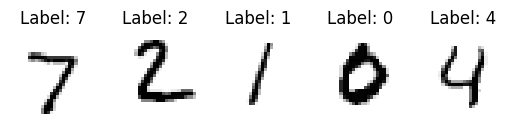

In [3]:
# download MNIST dataset
X_train, y_train, X_test, y_test = load_MNIST_28(flatten_images=True)

# Display some images
for i, image in enumerate(X_test[0:5]):
    plt.subplot(1, 5, i+1)
    plt.axis('off')
    n = int((image.shape[0])**(1/2))
    plt.imshow(image.reshape(n,n), cmap=plt.cm.gray_r, interpolation='nearest')
    plt.title(f"Label: {np.argmax(y_test[i])}")
plt.show()

### Single run

100%|██████████| 50/50 [07:39<00:00,  9.20s/it]


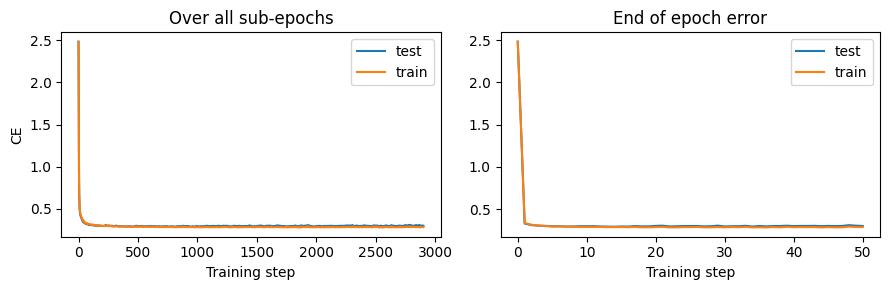

test:  0.9244999885559082
train:  0.9292500019073486
CE test:  0.29934493
CE train:  0.28630823


In [5]:
def single_run(X_train, X_test, y_train, y_test, 
               lr, lam, epochs=300, batch_size=32, 
               plot_or_not=False, result_filepath=None, store_params=False):
    
    """
    Performs a training with the given parameters

    Returns result, including the final accuracy scores
    """

    # Initialise beta and create the model
    beta0 = softmax_beta_init(input_shape=X_train.shape[1], output_shape=y_train.shape[1])
    model = softmax_model

    # Create gradient from loss function. Ridge loss lets us use MSE by lam=0
    loss_func = jit(cross_entropy_loss_method(model=model, lam=lam))
    loss_grad = jit(grad(loss_func))

    # (usually MSE) loss function for evaluation
    if plot_or_not:
        test_func = jit(MSELoss_method(model))
        test_func = loss_func
    else:
        test_func = None

    # Perform training. We use adam, add the test index
    result = SGD_adam(X_train, y_train, X_test, y_test, 
                      grad_method=loss_grad,beta0=beta0, 
                      n_epochs=epochs, batch_size=batch_size,
                      test_loss_func= test_func, lr=lr)

    # Plot if wanted ...
    if plot_or_not:
        n_batches = int(y_train.shape[0] / batch_size)
        plot_test_results(result["test_loss_list"], result["train_loss_list"], n_batches, ylabel="CE")

    # Add accuracy scores
    result["test_accuracy"]  = accuracy_func(model, result["beta_final"], X_test, y_test)
    result["train_accuracy"] = accuracy_func(model, result["beta_final"], X_train, y_train)
    # Also store the model for potential later use
    result["model"] = model

    # Store the result to given file
    if result_filepath:
        _list_to_store = [{"test_accuracy"     : result["test_accuracy"], 
                           "train_accuracy"    : result["train_accuracy"],
                           "lr"                : lr, 
                           "lam"               : lam,
                           "epochs"            : epochs,
                           "batch_size"        : batch_size}]
        if store_params:
            _list_to_store[0]["beta_final"] = {key: value.tolist() for key, value in result["beta_final"].items()}
        append_run_to_file(result_filepath, _list_to_store)

    return result


## A demonstration
epochs = 50
batch_size = 1024
result = single_run(X_train, X_test, y_train, y_test, 
                    lr=0.01, lam=0.0001, epochs=epochs, batch_size=batch_size,
                    plot_or_not=True, result_filepath="test.json")

print("test: ", result["test_accuracy"])
print("train: ", result["train_accuracy"])

print("CE test: ", result["test_loss_list"][-1])
print("CE train: ", result["train_loss_list"][-1])

### Learning rate, batch size and epoch number